In [1]:
import repackage
repackage.up()

from datasets.nuscenes import NuScenesMultipleRadarMultiSweeps
from utils.occupancy import *
from utils.labelling import *
from utils.transforms import *
from utils.postprocessing import *
from utils.ransac_solver import RANSACSolver
from utils.motion_estimation import *
from autolabeler import AutoLabeler
import pandas as pd
import os.path as osp
import numpy as np
import open3d as o3d
from pathlib import Path
from nuscenes import NuScenes
from multiprocessing import cpu_count, Pool, set_start_method
import matplotlib
import matplotlib.pyplot as plt
from utils.visualization import map_pointcloud_to_image, render_pointcloud_in_image, plot_maps
from utils.motion_estimation import remove_dynamic_points


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Full Pipeline

Testing on a single row of the matched scenes dataframe

In [2]:
DATA_DIR = "/shared/data/nuScenes/"
versions = {'trainval': 'v1.0-trainval', 'test': 'v1.0-test'}
nuscenes_exp = {
    vname: NuScenes(dataroot=DATA_DIR, version=version, verbose=False)
    for vname, version in versions.items()
}

In [3]:
ref_frame = None
NUM_SWEEPS = 5
ref_sensor = None
filter_points = False

DPR_THRESH = 0.15
OCTOMAP_RESOLUTION = 0.15 # For dividing space, for lidar 0.1 is suitable but since radar is sparse a larger value might be better
VOXEL_SIZE = 0.01

DF_PATH = '../sps_nuscenes_more_matches_df.json'
sps_df = pd.read_json(DF_PATH)


ICP_FILTERING = True
SEARCH_IN_RADIUS = True
RADIUS = 1
USE_LIDAR_LABELS = False
USE_OCCUPANCY_PRIORS = True
FILTER_BY_POSES = False
FILTER_BY_RADIUS = False
FILTER_OUT_OF_BOUNDS = False
USE_COMBINED_MAP = True


SENSORS = ["RADAR_FRONT", "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]

In [4]:
sps_df.head()

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
121,scene-0161,1526922443042,0,0.000000,May,trainval,[scene-0218],{'scene-0218': {'scene_token': 'febc1800b9ed43...
122,scene-0162,1526922463034,0,0.005553,May,trainval,"[scene-0665, scene-0218, scene-0219]",{'scene-0665': {'scene_token': '45275e709d4a4b...
123,scene-0163,1526922483050,0,0.011113,May,trainval,"[scene-0075, scene-0511, scene-0332, scene-045...",{'scene-0075': {'scene_token': '01c3f5e3995640...
124,scene-0164,1526922518041,0,0.020833,May,trainval,"[scene-0513, scene-0091]",{'scene-0513': {'scene_token': 'e333874a12d64a...
125,scene-0165,1526922555077,0,0.031121,May,trainval,"[scene-0092, scene-0333, scene-0265, scene-0062]",{'scene-0092': {'scene_token': '7365495b744646...


In [5]:
row = sps_df[sps_df.scene_name == 'scene-0162'].iloc[0]

In [6]:
ref_scene_name = row['scene_name']
ref_split = row['split']
closest_scenes = row['closest_scenes_data']

In [7]:
## Create Dataloader for each scene in a record
dataloaders = {ref_scene_name : NuScenesMultipleRadarMultiSweeps(
    data_dir=DATA_DIR,
    nusc=nuscenes_exp[ref_split],
    sequence=int(ref_scene_name.split("-")[-1]),
    sensors=SENSORS,
    nsweeps=NUM_SWEEPS,
    ref_frame=ref_frame,
    ref_sensor=ref_sensor,
    apply_dpr=False,
    filter_points=filter_points,
    ransac_threshold=DPR_THRESH,
    combine_velocity_components=False

)}

for matched_scene, data in closest_scenes.items():
    dataloaders[matched_scene] = NuScenesMultipleRadarMultiSweeps(
    data_dir=DATA_DIR,
    nusc=nuscenes_exp[data['split']],
    sequence=int(matched_scene.split("-")[-1]),
    sensors=SENSORS,
    nsweeps=NUM_SWEEPS,
    ref_frame=ref_frame,
    ref_sensor=ref_sensor,
    apply_dpr=False,
    filter_points=filter_points,
    ransac_threshold=DPR_THRESH,
    combine_velocity_components=False
)

dataloaders.keys()

dict_keys(['scene-0162', 'scene-0665', 'scene-0218', 'scene-0219'])

In [8]:
scene_pointclouds = {name : [dl[i][0] for i in range(dl.num_readings)] for name,dl in dataloaders.items()}
scene_calibs = {name : [dl[i][1] for i in range(dl.num_readings)] for name,dl in dataloaders.items()}
scene_poses = {name: dl.global_poses for name,dl in dataloaders.items()}

In [9]:
# inliers_dict, global_scene_pointclouds = process_point_clouds(scene_pointclouds, scene_calibs, scene_poses, use_ransac=True, threshold=1)
# scene_maps = {name : np.vstack(pcls) for name,pcls in global_scene_pointclouds.items()}
# scene_dpr_masks = {name : np.hstack(masks) for name,masks in inliers_dict.items()}

In [10]:
scene_pointclouds_dpr_masks, global_scene_pointclouds = remove_dynamic_points(scene_pointclouds, scene_calibs, scene_poses, SENSORS, filter_sensors=True, dpr_thresh=DPR_THRESH, save_vis=False)

In [11]:
scene_dpr_masks = {name : np.hstack(masks) for name,masks in scene_pointclouds_dpr_masks.items()}
scene_maps = {name : np.vstack(pcls) for name,pcls in global_scene_pointclouds.items()}

In [12]:
def plot_dpr_masks(scene, map_pcl, mask):
    plt.figure(figsize=(10, 10))
    
    plt.scatter(map_pcl[:, 0], map_pcl[:, 1], s=0.25, label='static', c='green', alpha=0.5)
    dpr_map = map_pcl[:len(mask)]
    dpr_map = dpr_map[~mask]
    plt.scatter(dpr_map[:, 0], dpr_map[:, 1], s=0.25, label='dynamic', c='red', alpha=0.5)
    plt.title(scene)
    plt.xlabel('X')
    plt.ylabel('Y')

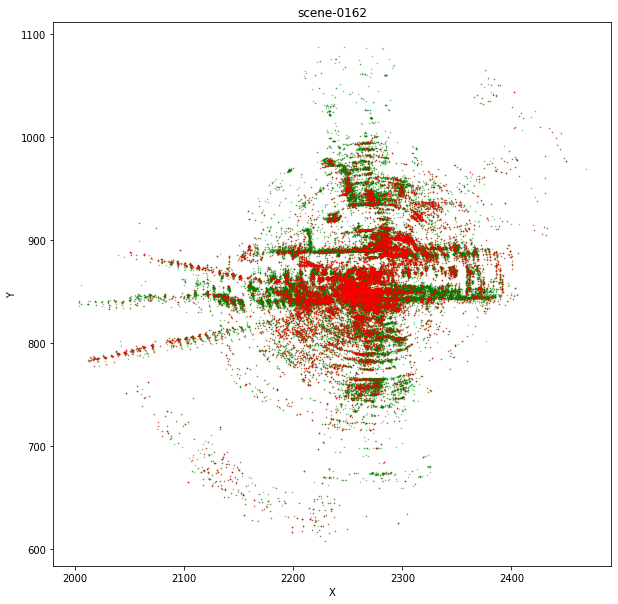

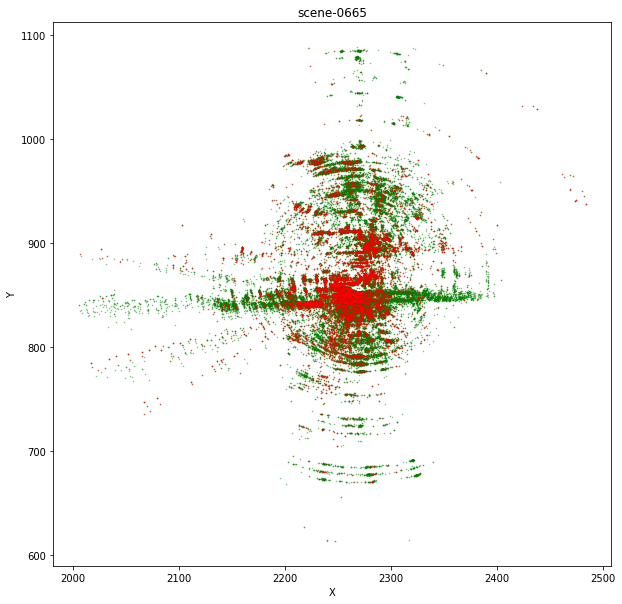

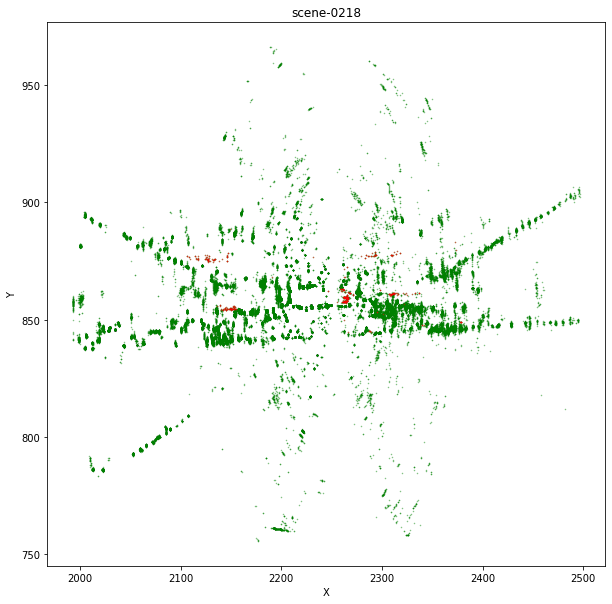

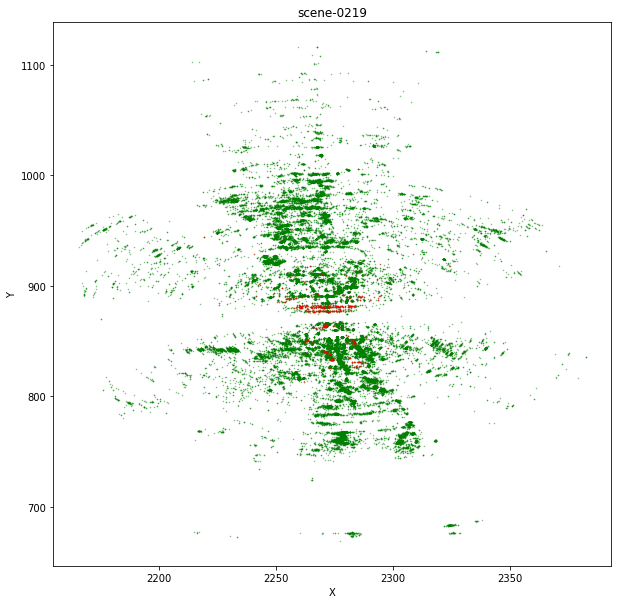

In [13]:
for scene_name in scene_maps:
    plot_dpr_masks(scene_name, scene_maps[scene_name], scene_dpr_masks[scene_name])

In [14]:
static_scene_maps = {}
dynamic_scene_maps = {}
dpr_sps_maps = {}

for name in scene_maps:
    indices = scene_dpr_masks[name]
    map_pcl = scene_maps[name]
    filtered_map_pcl = map_pcl[indices]
    static_scene_maps[name] = filtered_map_pcl
    dynamic_scene_maps[name] = map_pcl[~indices]
    dpr_scores = np.array(indices).astype(np.int).reshape(-1, 1)
    dpr_sps_pcl = np.hstack((map_pcl, dpr_scores))
    dpr_sps_maps[name] = dpr_sps_pcl

In [15]:
scene_name= list(scene_maps.keys())[2]
print(scene_name)
dataset_sequence = dataloaders[scene_name]
sample_token = dataset_sequence.scene['first_sample_token']
sample = nuscenes_exp[ref_split].get('sample', sample_token)

scene-0218


In [16]:
sample_token = sample['next']
if sample_token:
    sample = nuscenes_exp[ref_split].get('sample', sample_token)
print(sample_token)

8d0a4c8bc0fe49d59f4357a50a9bb815


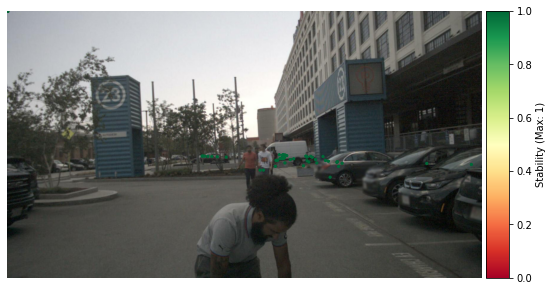

In [17]:
viewpoint = [('RADAR_FRONT', 'CAM_FRONT'), ('RADAR_BACK_LEFT', 'CAM_BACK')]
vidx = 0
render_pointcloud_in_image(
    nuscenes_exp[ref_split],
    dpr_sps_maps[scene_name],
    sample['token'],
    pointsensor_channel=viewpoint[vidx][0],
    camera_channel=viewpoint[vidx][1]
)

In [18]:
# from utils.visualization import setup_directories, save_plots_for_scene, create_video_from_plots
# base_dir = 'output_videos'
# setup_directories(base_dir, scene_name)
# save_plots_for_scene(nuscenes_exp[ref_split], base_dir, scene_name, sample_token, dpr_sps_maps[scene_name])
# create_video_from_plots(base_dir, scene_name)

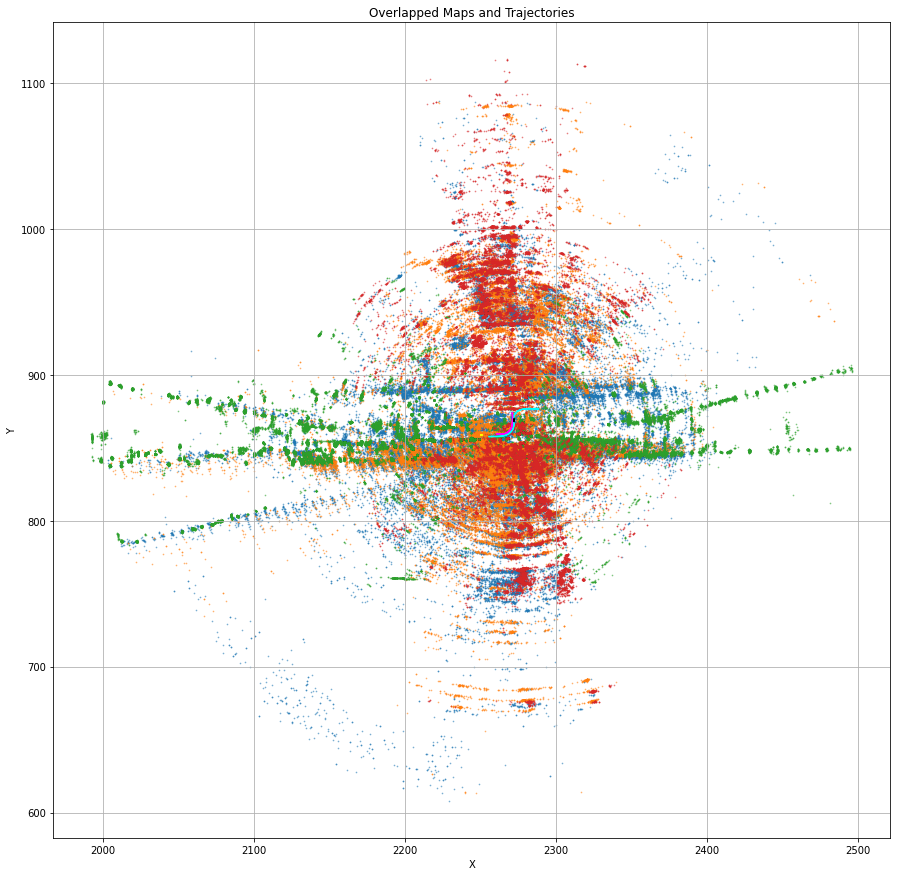

In [19]:
plot_maps(scene_maps=scene_maps, poses=scene_poses, zoom_level=-1)

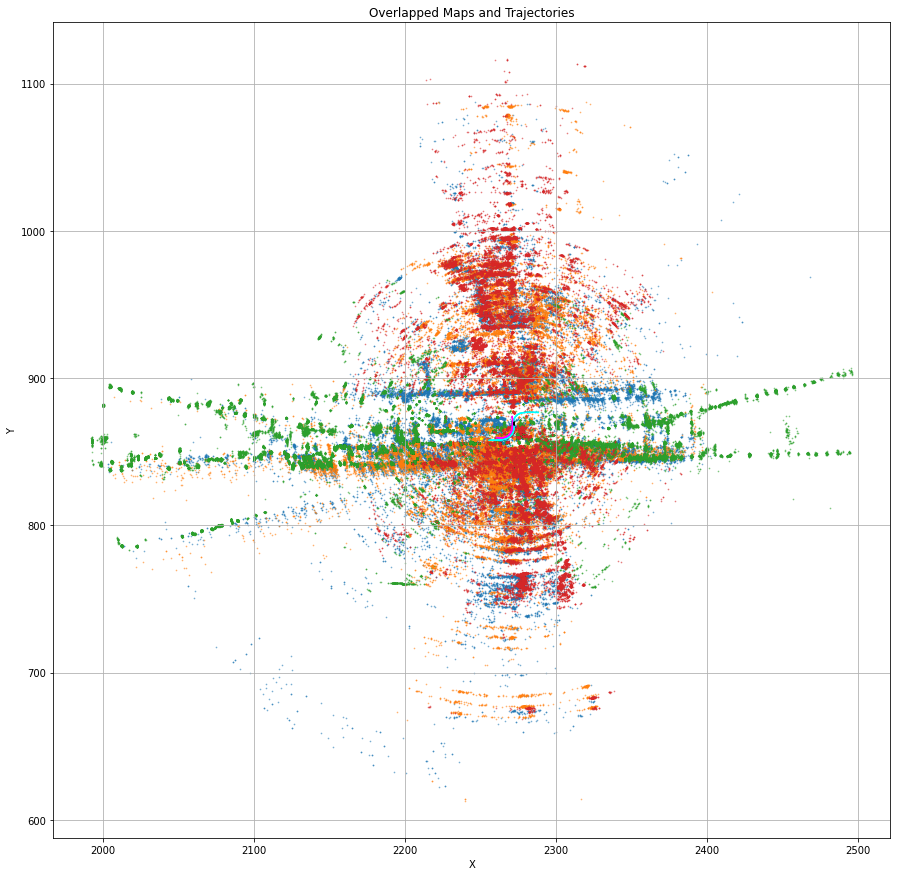

In [20]:
plot_maps(scene_maps=static_scene_maps, poses=scene_poses, zoom_level=-1)

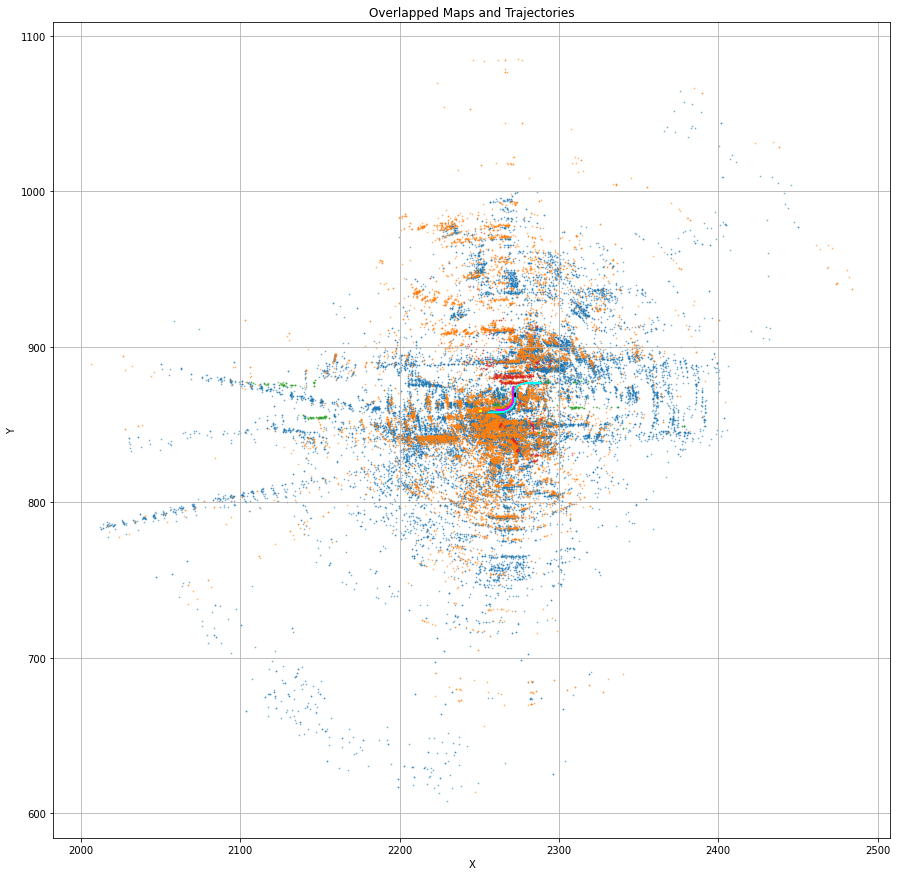

In [21]:
plot_maps(scene_maps=dynamic_scene_maps, poses=scene_poses, zoom_level=-1)

### Post-processing via ICP filtering

In [22]:
cropped_scene_maps = filter_maps_icp(static_scene_maps)

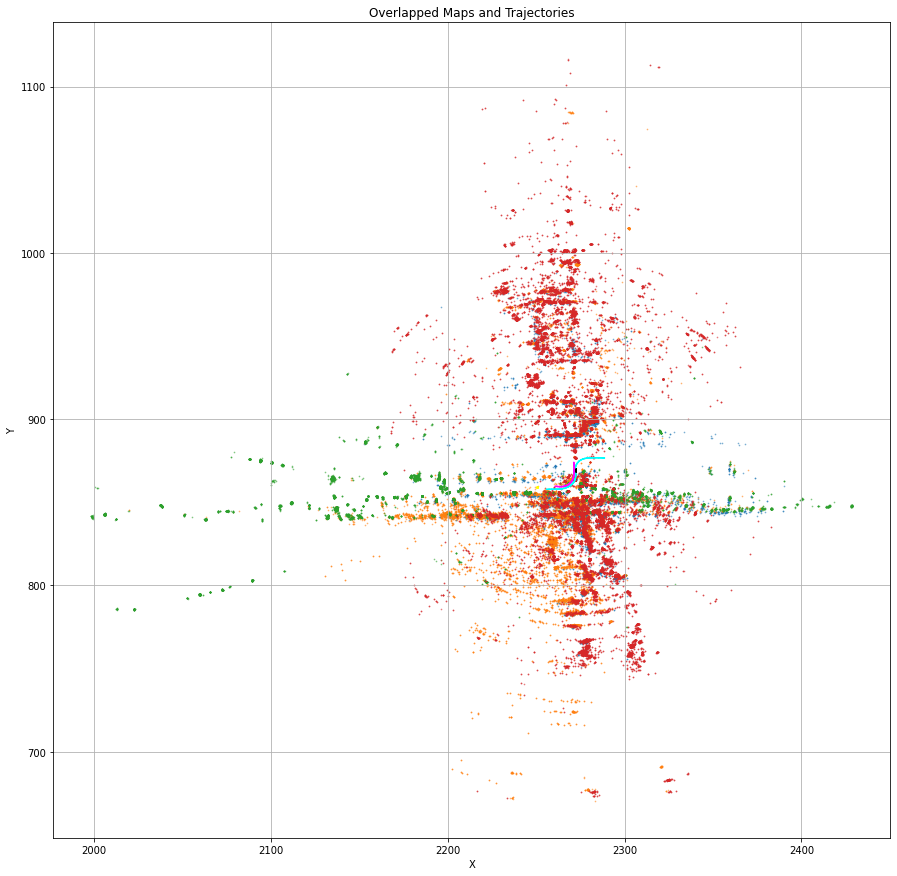

In [23]:
plot_maps(cropped_scene_maps, poses=scene_poses, zoom_level=-1)

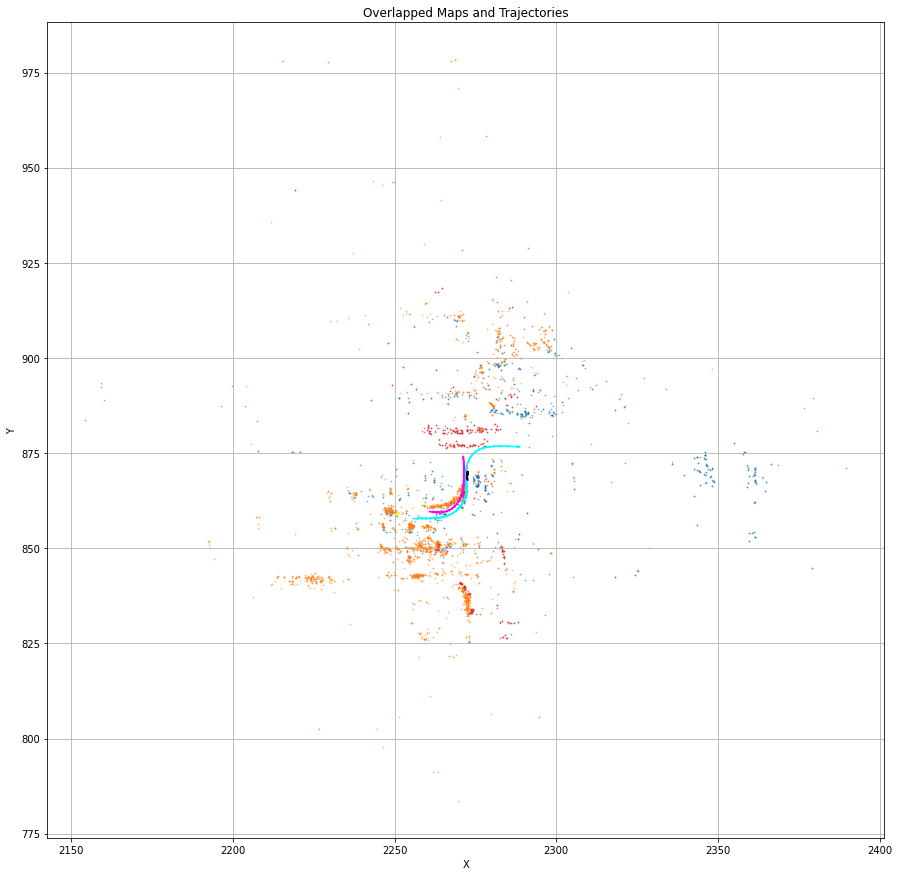

In [24]:
dynamic_scene_maps = filter_maps_icp(dynamic_scene_maps, alignment_thresh=0.5, overlapping_thresh=0.25)
plot_maps(dynamic_scene_maps, poses=scene_poses, zoom_level=-1)

### Dynamic/Occupancy Voxel priors

In [25]:
scene_scans = {name: {i:global_scene_pointclouds[name][i][:,:3] for i in range(len(dataloader))} for name,dataloader in dataloaders.items()}

In [26]:
scene_voxel_maps = {name : create_voxel_map(scans, voxel_size=VOXEL_SIZE) for name,scans in scene_scans.items()}

In [27]:
# plot_voxel_map(scene_voxel_maps[ref_scene_name], voxel_size=VOXEL_SIZE)

### Octomaps

In [28]:
scene_octomaps = {name: build_octomap(dl, resolution=OCTOMAP_RESOLUTION) for name,dl in dataloaders.items()}

100%|██████████| 44/44 [00:11<00:00,  3.85it/s]


In [29]:
# plot_occupancy_score_dist(scene_octomaps[ref_scene_name])

### Stable-Point Labeler

In [40]:
sps_labeler = AutoLabeler(
    scene_maps=scene_maps, ref_map_id=list(scene_poses.keys())[0], scene_poses=scene_poses,
    scene_octomaps=scene_octomaps, lidar_labels=None,
    dynamic_priors=scene_voxel_maps, use_octomaps=True,
    search_in_radius=SEARCH_IN_RADIUS, radius=RADIUS, use_combined_map=USE_COMBINED_MAP,
    downsample=True, voxel_size=VOXEL_SIZE, filter_out_of_bounds=FILTER_OUT_OF_BOUNDS
)

In [41]:
sps_labeler.label_maps()

Extracting features for scene-0162...


100%|██████████| 61227/61227 [03:51<00:00, 264.97it/s]


Extracting features for scene-0665...


100%|██████████| 52037/52037 [03:32<00:00, 245.31it/s]


Extracting features for scene-0218...


100%|██████████| 26026/26026 [02:15<00:00, 192.43it/s]


Extracting features for scene-0219...


100%|██████████| 29252/29252 [02:24<00:00, 202.95it/s]


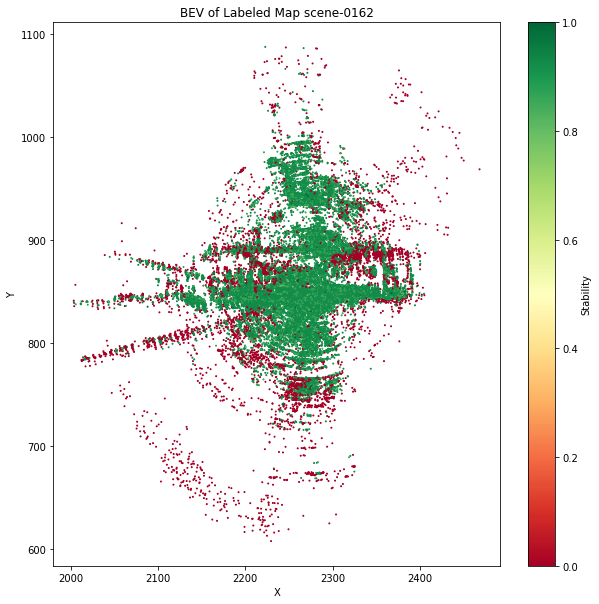

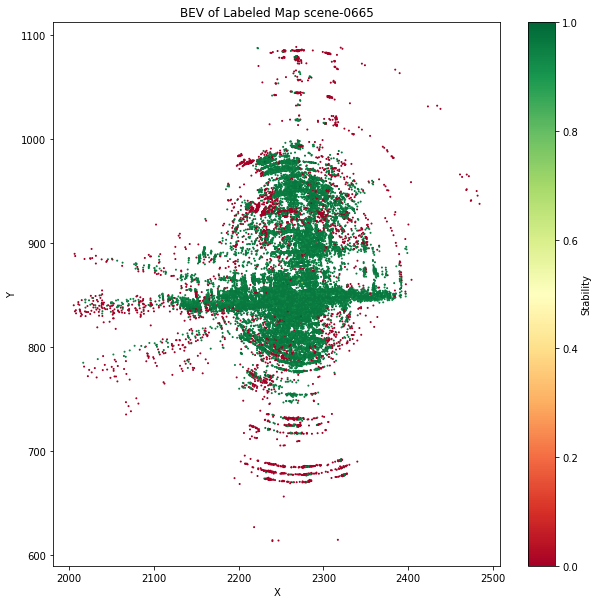

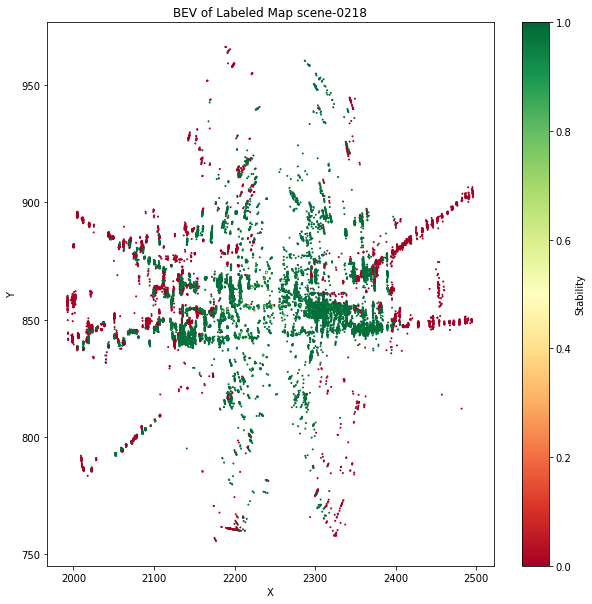

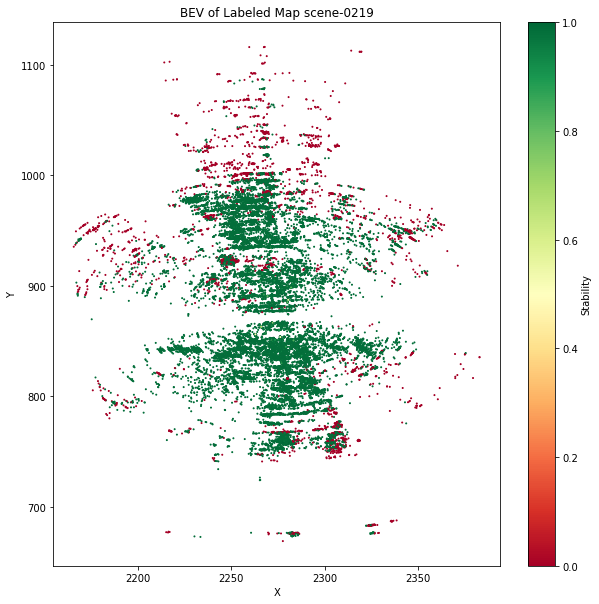

In [42]:
for name in sps_labeler.maps_ids:
    sps_labeler.plot_labeled_map_bev(map_id=name)

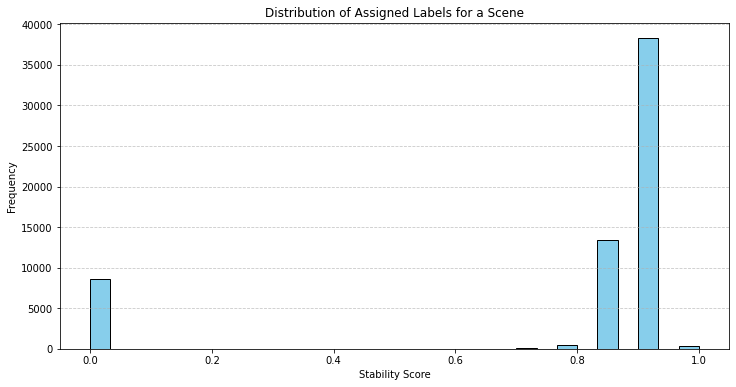

In [43]:
labels_dist = sps_labeler.labelled_maps[ref_scene_name][:,-1]
plt.figure(figsize=(12, 6))
plt.hist(labels_dist, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Assigned Labels for a Scene')
plt.xlabel('Stability Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [44]:
sample_scan, scan_calibs, sensors, ts = dataloaders[ref_scene_name][0]
pose = dataloaders[ref_scene_name].global_poses[0]
global_scan = []
for (pcl, calib) in zip(sample_scan, scan_calibs):
    ego_pcl = transform_doppler_points(calib, pcl)
    global_pcl = transform_doppler_points(pose, ego_pcl)
    global_scan.append(global_pcl)
global_scan = np.vstack(global_scan)
global_scan.shape

(2285, 9)

In [46]:
labelled_scan = sps_labeler.label_scan(global_scan)

Registering scan to combined environment map...


100%|██████████| 2285/2285 [00:11<00:00, 192.16it/s]


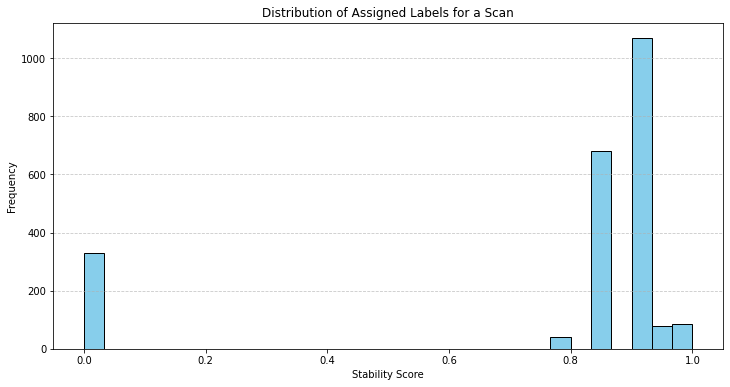

In [47]:
labels_dist = labelled_scan[:,-1]
plt.figure(figsize=(12, 6))
plt.hist(labels_dist, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Assigned Labels for a Scan')
plt.xlabel('Stability Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

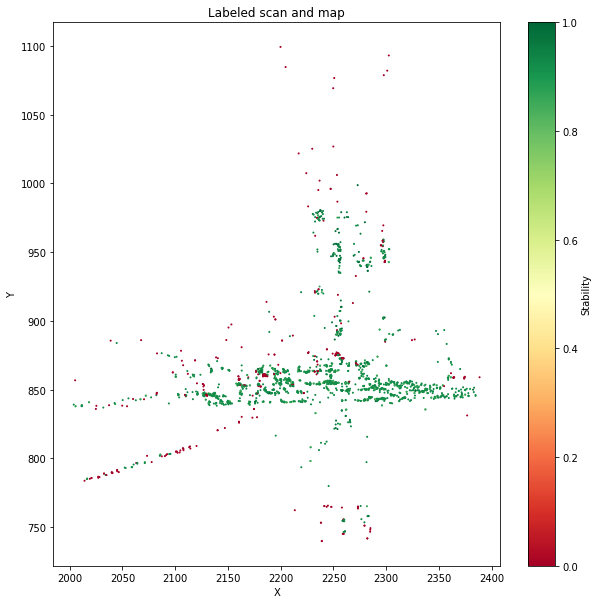

In [48]:
sps_labeler.plot_labeled_scan_bev(labelled_scan)

### Combining the DPR labels and AutoLabeler labels

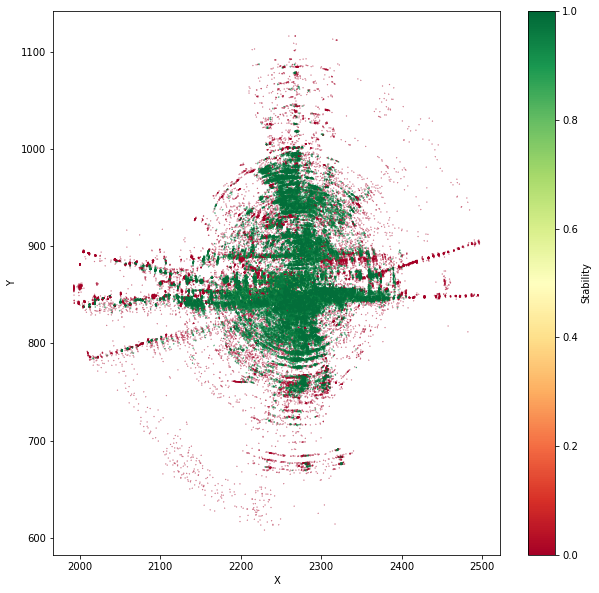

In [49]:
labeled_map = sps_labeler.labeled_environment_map
points = labeled_map[:, :3]
labels = labeled_map[:, -1]

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=0.05)
plt.colorbar(label='Stability')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [51]:
complete_sps_labelled_map = sps_labeler.labeled_environment_map

dynamic_sps_scene_points = {}
for name in dynamic_scene_maps:
    dyn_sps_pcl = np.hstack((dynamic_scene_maps[name], np.zeros(len(dynamic_scene_maps[name])).astype(np.int).reshape(-1, 1)))
    dynamic_sps_scene_points[name] = dyn_sps_pcl


for scene_name, dyn_points in dynamic_sps_scene_points.items():
    complete_sps_labelled_map = np.vstack([complete_sps_labelled_map, dyn_points])

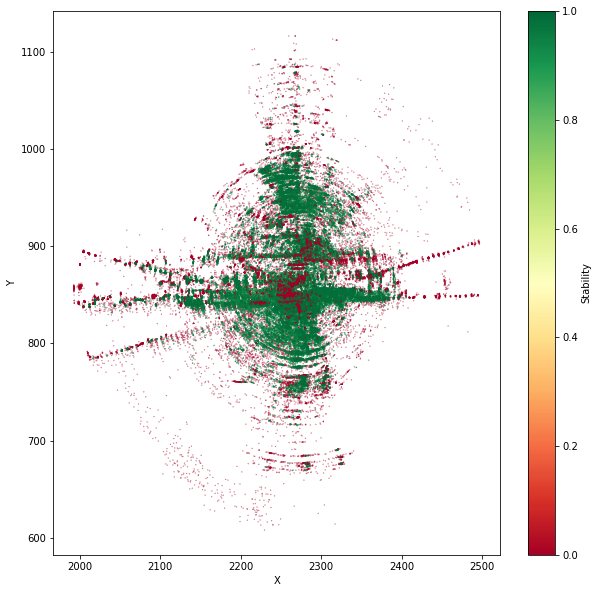

In [52]:
labeled_map = complete_sps_labelled_map
points = labeled_map[:, :3]
labels = labeled_map[:, -1]

mean_point = np.mean(points, axis=0) # color rescaling fix
points = np.vstack([points, mean_point, mean_point + 1])
labels = np.hstack([labels, [0, 1]])

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=0.05)
plt.colorbar(label='Stability')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# labels_dir = "labelled_maps/dynamic_prior_5sweep_radius_corr_fixed_dpr/"
# from pathlib import Path
# Path(labels_dir).mkdir(parents=True, exist_ok=True)

# for map_name, lmap in sps_labeler.labelled_maps.items():
#     points = lmap[:, :3]
#     stable_probs = lmap[:,-1]
#     filename = f"{labels_dir}/{map_name}.asc"
#     np.savetxt(filename,
#                np.hstack([points,stable_probs.reshape(-1,1)]),
#                fmt='%.6f', delimiter=' ',
#                header='x y z stable_prob',
#                comments='')    